In [5]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import copy

import torch as th
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [111]:
trajectory_potential = np.zeros((100 ,100))
trajectory_potential = np.pad(trajectory_potential, 7, mode='constant',constant_values=1)  
# trajectory potential update matrix
traj_update_size = 15
traj_update_mat = np.zeros((traj_update_size ,traj_update_size))
for i in range((traj_update_size//2)+1):
    traj_update_mat[i:traj_update_size-i,i:traj_update_size-i] = i**2
traj_update_mat= (traj_update_mat - np.min(traj_update_mat))/np.ptp(traj_update_mat)

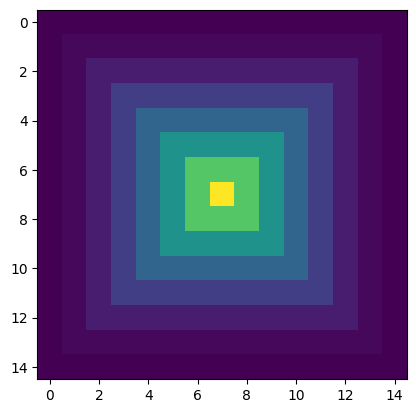

In [90]:
plt.imshow(traj_update_mat)

In [91]:
border_potential = np.ones((100,100))
for i in range(8):
    border_potential[i:100-i,i:100-i] = (7-i)**2
border_potential= (border_potential - np.min(border_potential))/np.ptp(border_potential)

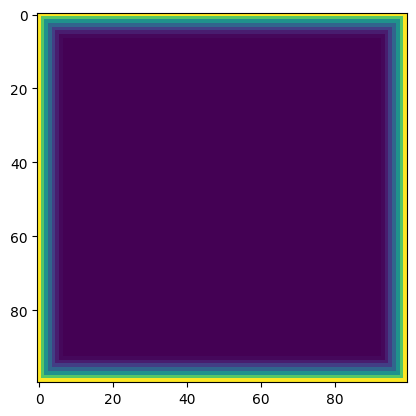

In [95]:
plt.imshow(border_potential)

In [112]:
import copy
direction = 0
pos = [10,10]
traj = [copy.copy(pos)]
for i in range(100):
    pos[direction]+=1
    traj.append(copy.copy(pos))
    if i%20==0:
        direction = abs(direction-1)   
        
for pos in traj:
    local_potential = trajectory_potential[pos[1]:pos[1]+traj_update_size,pos[0]:pos[0]+traj_update_size]
    trajectory_potential[pos[1]:pos[1]+traj_update_size,pos[0]:pos[0]+traj_update_size] = np.maximum(local_potential, traj_update_mat)

In [117]:
offset = traj_update_size // 2
potential_field = np.maximum(border_potential*1.5, trajectory_potential[offset:offset+100,offset:offset+100])
potential_field= (potential_field - np.min(potential_field))/np.ptp(potential_field)

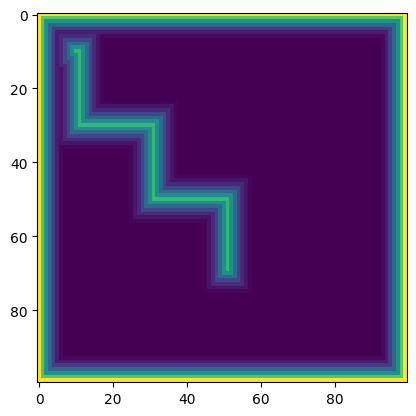

In [118]:
plt.imshow(potential_field)

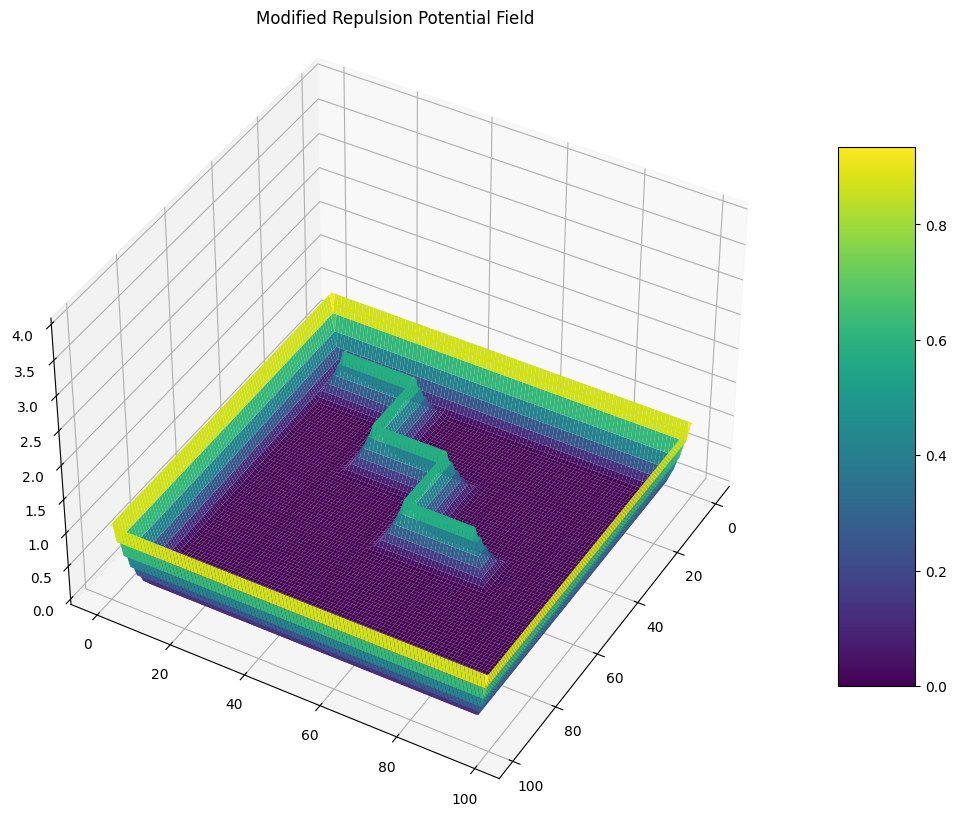

In [124]:
x = np.linspace(0, 99, 100)
y = np.linspace(0, 99, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize =(15, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, potential_field, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Modified Repulsion Potential Field')
ax.set_zlim(0, 4)
ax.view_init(elev=40, azim=30)
fig.colorbar(surf, ax = ax, shrink = 0.7, aspect = 7) 

In [17]:
ACTION_MAP = {0:"left",1:"right",2:"up",3:"down",4:"up-left",5:"up-right",6:"down-left",7:"down-right"}
ACTIONS = ["left", "right", "up", "down", "up-left", "up-right", "down-left", "down-right"]
ACTION_OFFSET = [[-1,0],[1,0],[0,-1],[0,1],[-1,-1],[1,-1],[-1,1],[1,1]]

class PotentialFieldEnvMini(gym.Env):
    def __init__(self, max_num_steps=400, size=100, vs_hsize=5):
        metadata = {'render.modes': ['human']}
        super(PotentialFieldEnvMini, self).__init__()
                    
        self.max_num_steps = max_num_steps       
        # Env Field
        self.size = size
        self.vs_hsize = vs_hsize
        self.field = np.zeros((3,size,size), dtype=np.uint8)
        
        # Setup potential field
        self.skip = 3
        self.setup_potential_fields()

        # Agent Field related params/variables
        self.num_steps = 0
        self.agent_position = None
        self.agent_trajectory = []

        # Action Space
        self.action_space_map = ACTION_MAP
        self.actions = ACTIONS
        self.action_space = spaces.Discrete(8)

        # Environment Observation space
        self.observation_space = spaces.Box(low=0, high=255, shape=(3,self.size, self.size), dtype=np.uint8)        

    def step(self, action_id):
        assert self.action_space.contains(action_id), "Action is invalid!"
        (next_position, hit_wall) = self.get_next_position(action_id)
        
        # Update number of steps
        self.num_steps += 1

        # Get any observations
        observations = {"location": next_position}

        # Update agent variables       
        self.agent_position = next_position
        self.agent_trajectory.append(self.agent_position)
        
        # Check for termination criteria
        done = (self.num_steps >= self.max_num_steps)
        reward = self.calculate_reward()
        
        # Record field values
        # next_state = np.expand_dims(self.field, axis=-1)
        next_state = self.get_env_state()
        self.update_traj_potential()
        
        return (next_state, reward, done, observations)

    def reset(self):
        # Reset agent related params
        self.num_steps = 0
        self.field = np.zeros((3,100,100), dtype=np.uint8)
        self.setup_potential_fields()
        self.agent_position = self.choose_random_start_position()
        self.agent_trajectory = []
        self.potential_penalty = None
        return self.get_env_state()
        
    def setup_potential_fields(self):
        # border potential (static)
        self.border_potential = np.ones((self.size,self.size))
        for i in range(8):
            self.border_potential[i:self.size-i,i:self.size-i] = (7-i)**2
        self.border_potential= (self.border_potential - np.min(self.border_potential))/np.ptp(self.border_potential)
        # trajectory potential
        self.traj_update_size = 15
        self.traj_offset = self.traj_update_size // 2
        self.trajectory_potential = np.zeros((self.size ,self.size))
        self.trajectory_potential = np.pad(self.trajectory_potential, self.traj_offset, mode='constant',constant_values=1)
        # trajectory potential update matrix
        self.traj_update_mat = np.zeros((self.traj_update_size, self.traj_update_size))
        for i in range(self.traj_offset+1):
            self.traj_update_mat[i:self.traj_update_size-i,i:self.traj_update_size-i] = i**2
        self.traj_update_mat = (self.traj_update_mat - np.min(self.traj_update_mat))/np.ptp(self.traj_update_mat)
    
    def update_traj_potential(self):
        if len(self.agent_trajectory) > self.skip:
            pos = self.agent_trajectory[-self.skip]
            local_potential = self.trajectory_potential[pos[1]:pos[1]+self.traj_update_size,pos[0]:pos[0]+self.traj_update_size]
            self.trajectory_potential[pos[1]:pos[1]+self.traj_update_size,pos[0]:pos[0]+self.traj_update_size] = np.maximum(local_potential, self.traj_update_mat)

    def get_env_state(self):
        # channel 1 --> agent position
        pos = self.agent_position
        min_x, max_x = pos[0] - self.vs_hsize, pos[0] + self.vs_hsize + 1
        min_y, max_y = pos[1] - self.vs_hsize, pos[1] + self.vs_hsize + 1
        self.field[0] = np.zeros((self.size, self.size),dtype=np.uint8)
        self.field[0,min_y:max_y, min_x:max_x] = 255
        # channel 2 --> traj potential field
        self.field[1] = (self.trajectory_potential[self.traj_offset:self.traj_offset+self.size,self.traj_offset:self.traj_offset+self.size] * 255).astype(np.uint8)
        # channel 3 --> border potential field
        self.field[2] = (self.border_potential * 255).astype(np.uint8)
        # print(pos)
        # plt.imshow(np.moveaxis(self.field, 0, 2))
        # plt.show()
        return self.field

    def choose_random_start_position(self):
        possible_starts = [[10,10]]
        return random.choice(possible_starts)

    def get_next_position(self, action_id):
        # Create a deepcopy of current state
        next_state = copy.deepcopy(self.agent_position)
        next_state = np.add(next_state, np.array(ACTION_OFFSET[action_id]))

        # Check for collisions
        hit_wall = False
        if ((next_state[0] < (0 + self.vs_hsize) or
             next_state[0] >= (self.size - self.vs_hsize)) or
            ((next_state[1] < (0 + self.vs_hsize) or
              next_state[1] >= (self.size - self.vs_hsize)))):
            # If the view scope is out of the field, hit_wall is set to True
            hit_wall = True
            next_state = np.array([np.maximum(self.vs_hsize,np.minimum(self.size - self.vs_hsize - 1,next_state[0])),\
                                   np.maximum(self.vs_hsize,np.minimum(self.size - self.vs_hsize - 1,next_state[1]))])
        return (next_state, hit_wall)
    
    def calculate_reward(self):
        min_x, max_x = self.agent_position[0] - self.vs_hsize, self.agent_position[0] + self.vs_hsize + 1
        min_y, max_y = self.agent_position[1] - self.vs_hsize, self.agent_position[1] + self.vs_hsize + 1     
        traj_potential = self.trajectory_potential[self.traj_offset+min_y:self.traj_offset+max_y, self.traj_offset+min_x:self.traj_offset+max_x]
        border_potential = self.border_potential[min_y:max_y,min_x:max_x]
        new_potential_penalty = np.sum(traj_potential + 1.5 * border_potential)
        if self.potential_penalty is not None:
            reward = self.potential_penalty - new_potential_penalty
        else:
            reward = 0
        self.potential_penalty = new_potential_penalty
        return reward

    def render(self, mode="human"):
        pass


In [18]:
class PPO_Agent:
    def __init__(self, env, name='PPO', path='./output', load_saved_model=False):
        self.env = env
        self.name = name
        self.model_path = os.path.join(path, name)
        self.checkpoint_callback = CheckpointCallback(
            save_freq=10000,
            save_path=f"{self.model_path}/checkpoints/",
            name_prefix=self.name,
            save_replay_buffer=True,
            save_vecnormalize=True,
        )
        if load_saved_model and os.path.exists(self.model_path+'.zip'):
            self.model = PPO.load(self.model_path, env=env)
        else:        
            self.model = PPO('CnnPolicy', env, verbose=0, tensorboard_log="./output/experiments/ppo_explore_tensorboard")
    
    def train(self, n_timestep=40_000, eval=True):
        self.model.learn(total_timesteps=n_timestep, progress_bar=False, callback=[self.checkpoint_callback])
        self.model.save(self.model_path)
        if eval:
            mean_reward, std_reward = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=10)
            print(f'Evaluation [{self.name}] ==> mean_reward: {mean_reward}, std_reward: {std_reward}')        

    def predict(self, obs, lstm_state=None, start=False):
        action, hidden_state  = self.model.predict(obs, state=lstm_state, episode_start=start)
        return action, hidden_state

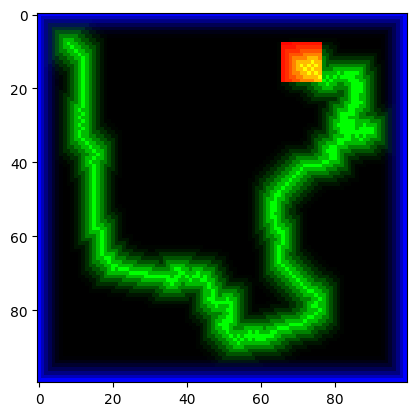

In [47]:
N_STEPS = 1_000_000
TEST_EPISODES = 1

# train & evaluate stable-baseline3 model
# env = PotentialFieldEnvMini()
# model = PPO_Agent(env, path='./output/experiments/')
# model.train(n_timestep=N_STEPS)

# evaluate
for episode_num in range(TEST_EPISODES):
    obs = env.reset()
    done = True
    steps = 0
    while True:
        action, hidden_state = model.predict(obs, start=done)
        obs, reward, done, observation = env.step(action.item())
        if done:
            plt.imshow(np.moveaxis(env.field, 0, 2))
            plt.show()
            break
        steps += 1